In [7]:
import warnings
warnings.filterwarnings("ignore")
import pyart
import numpy as np
import os
import glob
import datetime
import pymeso.vortex
from pymeso import llsd
# import wradlib as wrl
import matplotlib.pyplot as plt
import time
import cartopy.crs as ccrs
from pymeso import llsd
from matplotlib.pyplot import cm
import matplotlib.colors as colors
plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.size'] = 14

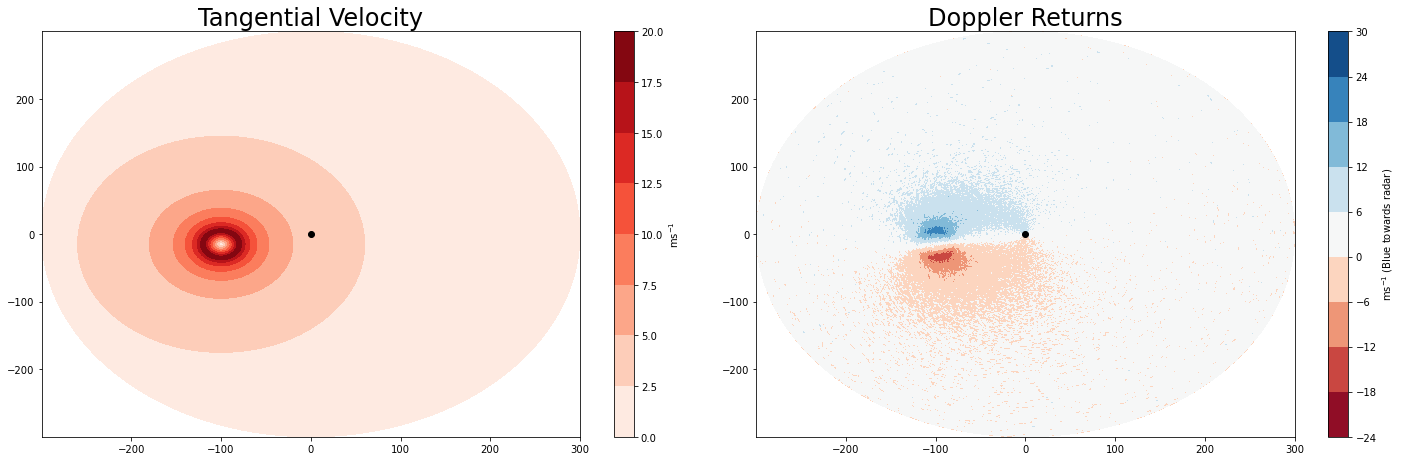

In [2]:
#run the vortex code with desired properties
x,y,U,V,doppler=pymeso.vortex.polar_vortex(beam=1,gate_size=.25,
                                           max_range=300,pos=[-100,-15],radius=20,
                                           vmax=20,clockwise=True,noise=True)

#calculate tangential velocity parameter for plotting
TV= np.sqrt(U**2+V**2)

#plot tangential velocity and doppler returns
fig = plt.figure(figsize=[20,12],facecolor='white')
ax1 = fig.add_subplot(221)
ax2 = fig.add_subplot(222)
fig.tight_layout()
neg2 = ax1.contourf((x), (y), TV, cmap=cm.Reds,) 
fig.colorbar(neg2, ax=ax1,label='ms$^{-1}$')
neg = ax2.contourf((x), (y), -doppler, cmap=cm.RdBu,) 
fig.colorbar(neg, ax=ax2,label='ms$^{-1}$ (Blue towards radar)')
ax1.set_title('Tangential Velocity',fontsize='24')
ax2.set_title('Doppler Returns',fontsize='24')
ax2.plot(0,0,'ko')
ax1.plot(0,0,'ko')

In [3]:
f = "/depot/dawson29/data/Projects/PERiLS/obsdata/2022/NEXRAD/IOP1/KGWX/KGWX20220322_214148_V06.nc"

In [4]:
#function to dealiase the Doppler velocity
def dealiase(radar, vel_name):
    #check to see if radar object has nyquist velocity
    try: 
        gatefilter = pyart.correct.GateFilter(radar)
        corr_vel   = pyart.correct.dealias_region_based(
            radar, vel_field=vel_name, keep_original=False, gatefilter = gatefilter)
        radar.add_field(vel_name, corr_vel, True)
    except:
        None

In [5]:
radar = pyart.io.read(f)
#dealiase Doppler field
dealiase(radar,'velocity')
#call the llsd function form llsd.py
start_time = time.time()
az_shear_meta = llsd.main(radar,'reflectivity','velocity')
print("LLSD COMPUTE --- %s seconds ---" % (time.time() - start_time))
radar.add_field('azi_shear', az_shear_meta, replace_existing=True)

/home/syed44/.conda/envs/cent7/2020.11-py38/syed/lib/python3.9/site-packages/pymeso/llsd.py:27: DeprecationWarning: Please use `median_filter` from the `scipy.ndimage` namespace, the `scipy.ndimage.filters` namespace is deprecated.
  smooth_data    = scipy.ndimage.filters.median_filter(data, 3)


LLSD COMPUTE --- 6.802484750747681 seconds ---


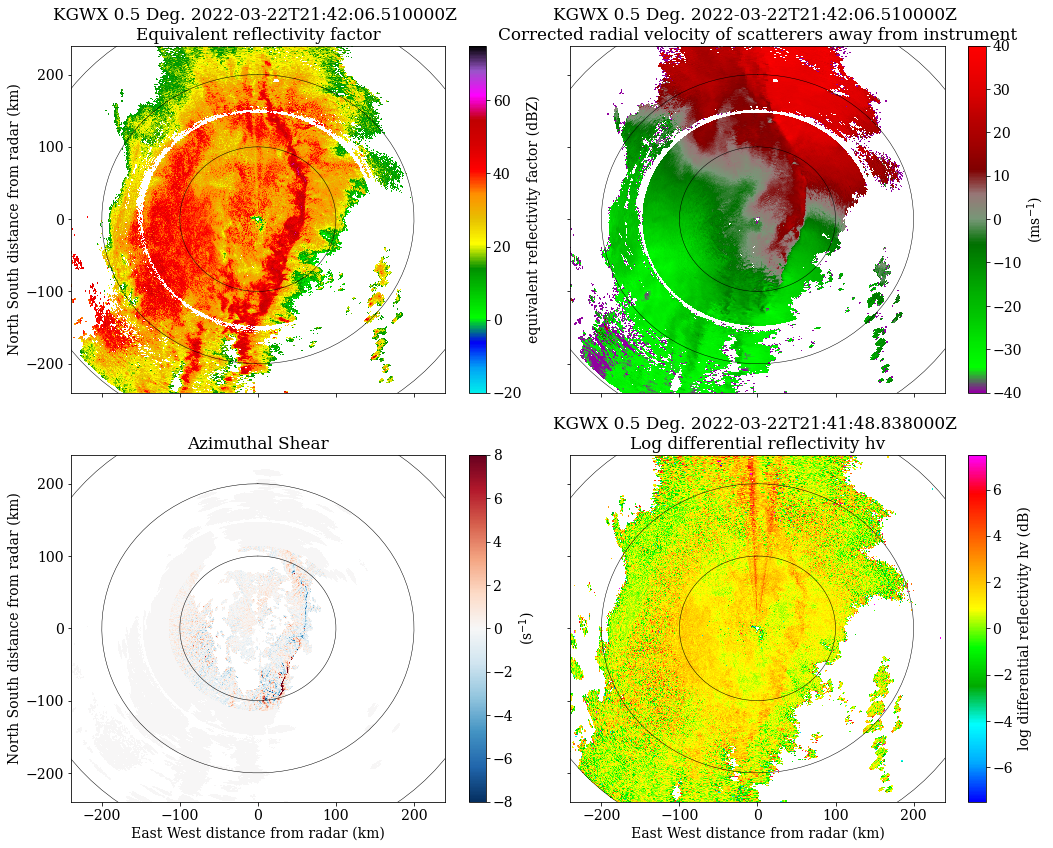

In [8]:
#define constants as required for plotting
tilt = 1
#plot reflectivity, Doppler velocity and llsd azimuthal shear using pyart
display = pyart.graph.RadarDisplay(radar)
fig = plt.figure(figsize=[15,12],tight_layout=True)

ax0 = plt.subplot(221)
display.plot("reflectivity", sweep=tilt, vmin=-20, vmax=75, cmap="pyart_NWSRef", ax=ax0)
ax0.set_xlabel(""); ax0.set_xticklabels("")

ax1 = plt.subplot(222)
display.plot('velocity', sweep=tilt, vmin=-40, vmax=40, colorbar_label='(ms$^{-1}$)',
             cmap=pyart.graph.cm.NWSVel, ax=ax1)
ax1.set_xticklabels(""); ax1.set_yticklabels("")
ax1.set_xlabel("");ax1.set_ylabel("")

ax2 = plt.subplot(223)
display.plot('azi_shear', sweep=tilt, title='Azimuthal Shear', vmin=-8, vmax=8, colorbar_label='(s$^{-1}$)',
                       cmap=cm.RdBu_r, ax=ax2)
ax3 = plt.subplot(224)
display.plot("differential_reflectivity",sweep=0,vmin=-7.5,vmax=7.5, cmap="pyart_RefDiff", ax=ax3)
ax3.set_yticklabels("")
ax3.set_ylabel("")

for ax in [ax0, ax1, ax2, ax3]:
    ax.set_xlim(-240, 240)
    ax.set_ylim(-240, 240)
    display.plot_range_rings([100,200,300],ax=ax,lw=0.5)